In [1]:
import os
import math
import random
import time
import warnings
import re
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
import texthero as hero
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

2021-08-31 00:11:21.460592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64:/usr/lib/x86_64-linux-gnu:/usr/local/lib64:/usr/local/cuda/lib64:/usr/lib64:/usr/lib/x86_64-linux-gnu:/usr/local/lib64:/usr/local/cuda/lib64:
2021-08-31 00:11:21.460663: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
!nvidia-smi

Tue Aug 31 00:13:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   30C    P8     8W / 250W |     12MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:06:00.0 Off |                  N/A |
| 23%   32C    P8     9W / 250W |      1MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
torch.cuda.is_available()

True

In [4]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [5]:
train_df.head()

,id,title,abstract,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0


In [6]:
border = len(train_df[train_df["judgement"] == 1]) / len(train_df["judgement"])
print(border)

0.023282372444280715


In [7]:
len(train_df)

27145

In [8]:
train_df.isnull().sum()

id              0
title           0
abstract     4390
judgement       0
dtype: int64

In [9]:
def clean_data(train_df):
    train_df.loc[train_df['abstract'].isnull(), 'abstract'] = train_df['title']
    return train_df

def get_texts(df):
    titles = df['title'].values.tolist()
    abstracts = df['abstract'].values.tolist()
    return titles, abstracts

def get_labels(df):
    labels = df.iloc[:, 3].values
    return labels
    
train_df = clean_data(train_df)
train_df.head()

,id,title,abstract,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,Prolonged shedding of SARS-CoV-2 in an elderly...,0


In [10]:
train_df.isnull().sum()

id           0
title        0
abstract     0
judgement    0
dtype: int64

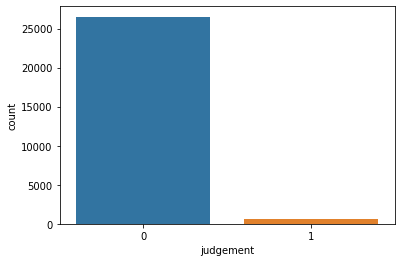

In [11]:
ax = sns.countplot(x='judgement', data=train_df)

<BarContainer object of 27145 artists>

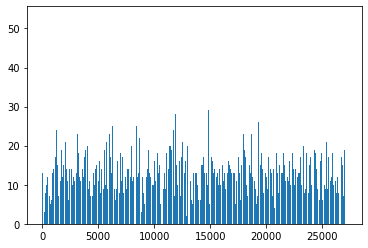

In [12]:
title = train_df['title'].tolist()
y = [len(t.split()) for t in title]
x = range(0, len(y))
plt.bar(x, y)

<BarContainer object of 27145 artists>

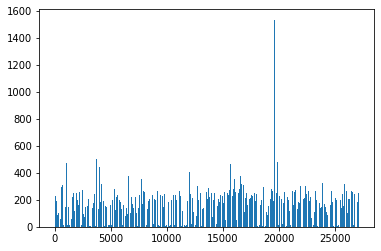

In [13]:
abstract = train_df['abstract'].tolist()
y = [len(a.split()) for a in abstract]
x = range(0, len(y))
plt.bar(x, y)

In [14]:
class Config:
    def __init__(self):
        super(Config, self).__init__()
        
        self.SEED = 42
        self.MODEL_PATH = 'allenai/scibert_scivocab_uncased'
        self.NUM_LABELS = 1
        
        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH1 = 24
        self.MAX_LENGTH2 = 512
        self.BATCH_SIZE = 4
        self.VALIDATION_SPLIT = 0.2
        
        self.DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 1e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 1
        self.EPOCHS = 5
        
config = Config()

In [15]:
def seed_init(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed = config.SEED
seed_init(seed)

In [16]:
class TransformerDataset(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset, self).__init__()

        df = df.iloc[indices]
        self.titles, self.abstracts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.max_length1 = config.MAX_LENGTH1
        self.max_length2 = config.MAX_LENGTH2
        self.tokenizer = config.TOKENIZER

    def __len__(self):
        return len(self.titles)
    
    def __getitem__(self, index):
        tokenized_titles = self.tokenizer.encode_plus(
            self.titles[index], 
            max_length=self.max_length1,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        input_ids_titles = tokenized_titles['input_ids'].squeeze()
        attention_mask_titles = tokenized_titles['attention_mask'].squeeze()
        
        tokenized_abstracts = self.tokenizer.encode_plus(
            self.abstracts[index], 
            max_length=self.max_length2,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        input_ids_abstracts = tokenized_abstracts['input_ids'].squeeze()
        attention_mask_abstracts = tokenized_abstracts['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'titles': {
                    'input_ids': input_ids_titles.long(),
                    'attention_mask': attention_mask_titles.long(),
                },
                'abstracts': {
                    'input_ids': input_ids_abstracts.long(),
                    'attention_mask': attention_mask_abstracts.long(),
                },
                'labels': torch.Tensor([self.labels[index]]).float(),
            }

        return {
            'titles': {
                'input_ids': input_ids_titles.long(),
                'attention_mask': attention_mask_titles.long(),
            },
            'abstracts': {
                'input_ids': input_ids_abstracts.long(),
                'attention_mask': attention_mask_abstracts.long(),
            }
        }

In [17]:
class DualSciBert(nn.Module):
    def __init__(self):
        super(DualSciBert, self).__init__()
        self.titles_model = AutoModel.from_pretrained(config.MODEL_PATH)
        self.abstracts_model = AutoModel.from_pretrained(config.MODEL_PATH)
        self.dropout = nn.Dropout(0.25)
        self.avgpool = nn.AvgPool1d(2, 2)
        self.output = nn.Linear(768, config.NUM_LABELS)
    
    def forward(self, input_ids_titles, attention_mask_titles=None, input_ids_abstracts=None, attention_mask_abstracts=None):
        output = self.titles_model(input_ids=input_ids_titles, attention_mask=attention_mask_titles)
        titles_features = output.pooler_output
        titles_features = titles_features.unsqueeze(1)
        titles_features_pooled = self.avgpool(titles_features)
        titles_features_pooled = titles_features_pooled.squeeze(1)
        
        output = self.abstracts_model(input_ids=input_ids_abstracts, attention_mask=attention_mask_abstracts)
        abstracts_features = output.pooler_output
        abstracts_features = abstracts_features.unsqueeze(1)
        abstracts_features_pooled = self.avgpool(abstracts_features)
        abstracts_features_pooled = abstracts_features_pooled.squeeze(1)
        
        combined_features = torch.cat((titles_features_pooled, abstracts_features_pooled), dim=1)
        x = self.dropout(combined_features)
        x = self.output(x)
        
        return x

In [24]:
def val(model, val_dataloader, criterion):
    val_loss = 0
    true, pred = [], []
    
    model.eval()
    
    for step, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        b_input_ids_titles = batch['titles']['input_ids'].to(device)
        b_attention_mask_titles = batch['titles']['attention_mask'].to(device)
        b_input_ids_abstracts = batch['abstracts']['input_ids'].to(device)
        b_attention_mask_abstracts = batch['abstracts']['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        
        with torch.no_grad():
            logits = model(b_input_ids_titles, b_attention_mask_titles, b_input_ids_abstracts, b_attention_mask_abstracts)
            loss = criterion(logits, b_labels)
            val_loss += loss.item()
            
            logits = torch.sigmoid(logits)
            logits = np.where(logits.to('cpu').detach().numpy().copy() < border, 0, 1)
            labels = b_labels.to('cpu').detach().numpy().copy()
            
            pred.extend(logits)
            true.extend(labels)
        
    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true, pred))
    
    val_micro_f1_score = f1_score(true, pred, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)
    return val_micro_f1_score

In [19]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch):
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp%100)
    validate_at_steps = [temp * x for x in range(1, nv+1)]
    
    train_loss = 0
    true, pred = [], []
    for step, batch in tqdm(enumerate(train_dataloader), desc='Epoch ' + str(epoch), total=len(train_dataloader)):
        
        model.train()
        b_input_ids_titles = batch['titles']['input_ids'].to(device)
        b_attention_mask_titles = batch['titles']['attention_mask'].to(device)
        b_input_ids_abstracts = batch['abstracts']['input_ids'].to(device)
        b_attention_mask_abstracts = batch['abstracts']['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(b_input_ids_titles, b_attention_mask_titles, b_input_ids_abstracts, b_attention_mask_abstracts)
        
        loss = criterion(logits, b_labels)
        train_loss += loss.item()
        
        logits = torch.sigmoid(logits)
        logits = np.where(logits.to('cpu').detach().numpy().copy() < border, 0, 1)
        labels = b_labels.to('cpu').detach().numpy().copy()
            
        pred.extend(logits)
        true.extend(labels)
            
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)
            
    avg_train_loss = train_loss / len(train_dataloader)
    accuracy = accuracy_score(true, pred)
    print('Training loss:', avg_train_loss)
    print('Training accuracy:', accuracy_score)
    return avg_train_loss, accuracy

In [20]:
def run(train_dataloader, val_dataloader, writer):
    criterion = nn.BCEWithLogitsLoss()
    
    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_parameters = [
            {
                "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.001,
            },
            {
                "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)
    
    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
    
    max_val_micro_f1_score = float('-inf')
    for epoch in range(config.EPOCHS):
        avg_train_loss, accuracy = train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_micro_f1_score = val(model, val_dataloader, criterion)
        
        writer.add_scalar('train_loss', avg_train_loss, epoch+1)
        writer.add_scalar('accuracy', accuracy)
        
        if config.SAVE_BEST_ONLY:
            if val_micro_f1_score > max_val_micro_f1_score:
                best_model = copy.deepcopy(model)
                best_val_micro_f1_score = val_micro_f1_score
                
    return best_model, best_val_micro_f1_score

In [21]:
def cross_val():
    Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    max_val_micro_f1_score = float('-inf')
    
    for n, (train_indices, val_indices) in enumerate(Fold.split(train_df, train_df['judgement'])):
        print(f'========= fold: {n} training =========')
        
        log_dir = 'logs/fold'+str(n)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        
        writer = SummaryWriter(log_dir=log_dir)

        train_data = TransformerDataset(train_df, train_indices)
        val_data = TransformerDataset(train_df, val_indices)
        
        train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
        val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)
                
        fold_best_model, fold_best_val_micro_f1_score = run(train_dataloader, val_dataloader, writer)
        
        if config.SAVE_BEST_ONLY:
            if fold_val_micro_f1_score > max_val_micro_f1_score:
                best_model = fold_best_model
                best_val_micro_f1_score = fold_val_micro_f1_score
                
                model_name = 'scibert_dualinput_best_model'
                torch.save(best_model.state_dict(), model_name+'.pt')
        
        writer.close()
                
    return best_model, best_val_micro_f1_score

In [22]:
device = config.DEVICE
device

device(type='cuda', index=1)

In [23]:
model = DualSciBert()
model.to(device)
best_model, best_val_micro_f1_score = cross_val()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing Ber

========= fold: 0 training =========


Epoch 0:   0%|          | 0/5429 [00:00<?, ?it/s]

/mnt/berry/home/s-kato/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 5400


  0%|          | 0/1358 [00:00<?, ?it/s]

NameError: name 'logitsto' is not defined

In [ ]:
dataset_size = len(test_df)
test_indices = list(range(dataset_size))
test_data = TransformerDataset(test_df, test_indices, set_type='test')
test_dataloader = DataLoader(test_data, batch_size=config.BATCH_SIZE)

def predict(model):
    val_loss = 0
    test_pred = []
    model.eval()
    for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        batch = batch[0]
        b_input_ids_titles = batch['titles']['input_ids'].to(device)
        b_attention_mask_titles = batch['titles']['attention_mask'].to(device)
        b_input_ids_abstracts = batch['abstracts']['input_ids'].to(device)
        b_attention_mask_abstracts = batch['abstracts']['attention_mask'].to(device)
        
        with torch.no_grad():
            logits = model(b_input_ids_titles, b_attention_mask_titles, b_input_ids_abstracts, b_attention_mask_abstracts)
            logits = torch.sigmoid(logits)
            logits = np.where(logits.to('cpu').detach().numpy().copy() < border, 0, 1)
            test_pred.extend(logits)
    
    test_pred = np.array(test_pred)
    return test_pred

test_pred = predict(best_model)

In [ ]:
def submit():
    sample_submission = pd.read_csv('data/sample_submit.csv', names=('id', 'judgement'))
    ids = sample_submission['id'].values.reshape(-1,1)
    
    merged = np.concatenate((ids, test_pred), axis=1)
    submission = pd.DataFrame(merged, columns=sample_submission.columns).astype(int)
    return submission

submission = submit()

In [ ]:
submission.to_csv('output/baseline.csv', index=False, header=False)

In [ ]:
#validation accuracyをtensorboardで管理
#k_foldのscoreの平均値を出す
#f1からbetaスコアに変える